In [1]:
from pathlib import Path

import torch as th
from conceptual import experiment, generate_bandlimited_experiment_data
from torch_gfrft import EigvalSortStrategy
from torch_gfrft.gfrft import GFRFT
from torch_gfrft.gft import GFT
from utils import (
    init_knn_from_mat,
    mse_loss,
    seed_everything,
    snr,
)

## Graph & JTV Signal Settings

In [2]:
SEED = 0
NODE_DIM = 0
KNN_COUNT = 10
KNN_SIGMA = None
MAX_NODE_COUNT = 100
MAX_TIME_LENGTH = 120
EIGVAL_SORT_STRATEGY = EigvalSortStrategy.TOTAL_VARIATION
NORMALIZE_JTV_SIGNAL = True
GRAPH_VERBOSE = True
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

Dataset Info:
	name: sea-surface-temperature
	node count: 100
	time length: 120
JTV Signal: min=0.0, max=1.0


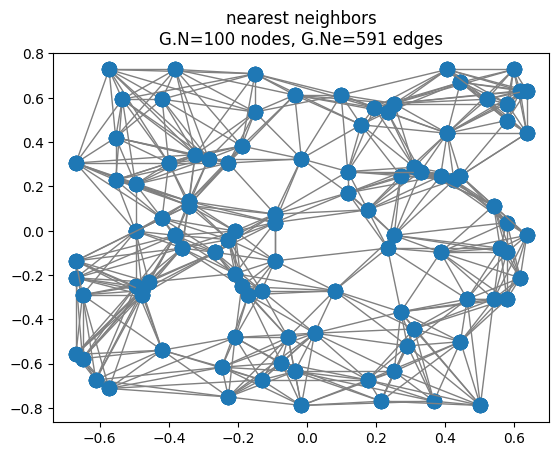

In [3]:
seed_everything(SEED)
datasets_path = Path.cwd().parent.joinpath("data", "tv-graph-datasets").absolute()
curr_dataset_path = datasets_path.joinpath("sea-surface-temperature.mat")
graph, adjacency, jtv_signal = init_knn_from_mat(
    curr_dataset_path,
    knn_count=KNN_COUNT,
    knn_sigma=KNN_SIGMA,
    max_node_count=MAX_NODE_COUNT,
    max_time_length=MAX_TIME_LENGTH,
    device=DEVICE,
    verbose=GRAPH_VERBOSE,
)
if NORMALIZE_JTV_SIGNAL:
    jtv_signal = (jtv_signal - jtv_signal.min()) / (jtv_signal.max() - jtv_signal.min())

print(f"JTV Signal: min={jtv_signal.min()}, max={jtv_signal.max()}")
gft = GFT(adjacency, EIGVAL_SORT_STRATEGY)
gfrft = GFRFT(gft.gft_mtx)

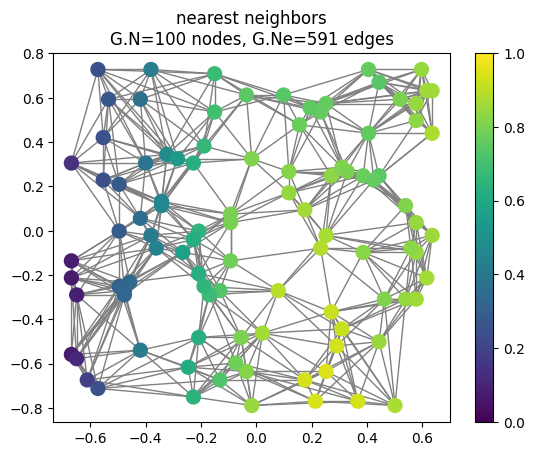

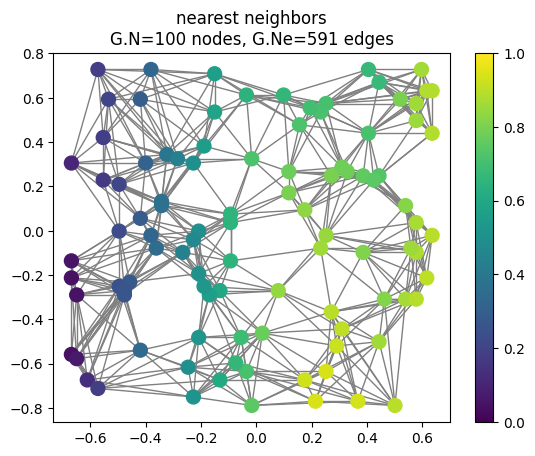

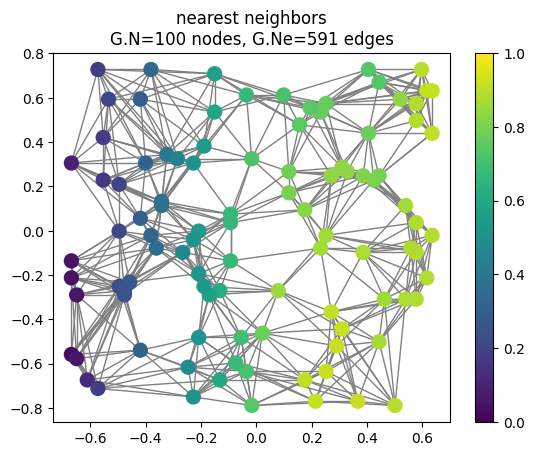

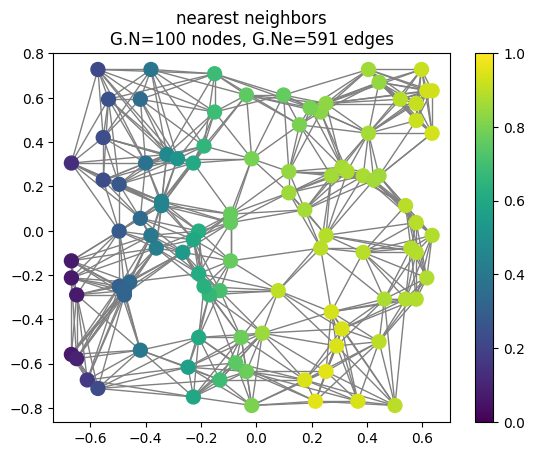

In [4]:
def display_jtv_signal(graph, jtv_signal, time_instances: list[int]) -> None:
    limits = [jtv_signal.min().floor().item(), jtv_signal.max().ceil().item()]
    for t in set(time_instances):
        gsignal = jtv_signal[..., t]
        graph.plot_signal(gsignal.cpu().numpy(), limits=limits)

display_jtv_signal(graph, jtv_signal, [0, 5, 10, 15])

In [5]:
def print_pre_info(bl_signal: th.Tensor, bl_noise: th.Tensor) -> None:
    bl_noisy_signal = bl_signal + bl_noise
    print(f"SNR: {snr(bl_signal, bl_noise):.2f}")
    print(f"MSE: {mse_loss(bl_signal, bl_noisy_signal):.2e}")


def print_after_info(
    model: th.nn.Module, bl_signal: th.Tensor, bl_noise: th.Tensor
) -> None:
    bl_noisy_signal = bl_signal + bl_noise
    with th.no_grad():
        estimated_signal = model(bl_noisy_signal)

    initial_mse = mse_loss(bl_signal, bl_noisy_signal)
    estimated_mse = mse_loss(bl_signal, estimated_signal)

    initial_snr = snr(bl_signal, bl_noisy_signal - bl_signal)
    estimated_snr = snr(bl_signal, estimated_signal - bl_signal)

    print(f"Initial SNR/MSE: {initial_snr:.2f}/{initial_mse:.2e}")
    print(f"Estimated SNR/MSE: {estimated_snr:.2f}/{estimated_mse:.2e}")

In [6]:
# Data generation
ORIGINAL_ORDER = 0.45
STOPBAND_COUNT = 30
OVERLAP_COUNT = 0
NOISE_MEAN = 0.0
NOISE_SIGMA = 0.6

# Model
INITIAL_ORDERS = [1.0]
CUTOFF_COUNTS = [STOPBAND_COUNT]
LEARNING_RATE = 5e-3
EPOCHS = 2000
TRAINABLE_TRANSFORM = True
TRAINABLE_FILTER = False

bl_signal, bl_noise = generate_bandlimited_experiment_data(
    gfrft=gfrft,
    signal=jtv_signal,
    order=ORIGINAL_ORDER,
    stopband_count=STOPBAND_COUNT,
    overlap=OVERLAP_COUNT,
    mean=NOISE_MEAN,
    sigma=NOISE_SIGMA,
)

print_pre_info(bl_signal, bl_noise)
model = experiment(
    gfrft=gfrft,
    jtv_signal=bl_signal,
    jtv_noise=bl_noise,
    initial_orders=INITIAL_ORDERS,
    cutoff_counts=CUTOFF_COUNTS,
    lr=LEARNING_RATE,
    epochs=EPOCHS,
    display_epochs=list(range(0, EPOCHS + 1, EPOCHS // 10)),
    trainable_transform=TRAINABLE_TRANSFORM,
    trainable_filter=TRAINABLE_FILTER,
    seed=SEED,
)
print(model)
print_after_info(model, bl_signal, bl_noise)

SNR: 4.95
MSE: 1.09e-01
Sequential(
  (0): GFRFTFilter(order=1.0 (trainable), filter=cutoff=30)
  (1): Real()
)
learning rate: 0.005


Initial Loss 0.1086 | SNR 4.948:   0%|          | 0/2000 [00:00<?, ?it/s]

Sequential(
  (0): GFRFTFilter(order=0.4500000774860382 (trainable), filter=cutoff=30)
  (1): Real()
)
Initial SNR/MSE: 4.95/1.09e-01
Estimated SNR/MSE: 141.31/2.51e-15
